In [664]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import os

In [665]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['figure.dpi'] = 70

In [666]:
TRAIN_DATA_FILES = glob.glob("data/train*")
TEST_DATA_FILES = glob.glob("data/test*")

In [764]:
data_file = TRAIN_DATA_FILES[0]
filename = os.path.split(data_file)[1]
dataset_id = filename[-1]
print("Loading dataset %s" % dataset_id)
data = pd.read_csv(data_file, sep=' ', header=None)

X_data, y_data = data[[0, 1]], data[2]
X_data = X_data.values
y_data = y_data.values

Loading dataset A


# Linear discriminant analysis

This generative model is given by a Gaussian mixture: the labels $y$ follow a Bernoulli distribution of parameter $\pi\in[0,1]$, with the likelihood of an antecedent $x$ given $y$ being
$$
    x|y=i \sim \mathcal{N}(\mu_i, \Sigma)
$$
where $\Sigma \in \mathcal S^{++}(\mathbb R^2)$.

The maximum likelihood estimates of the parameters $(\pi, (\mu_i), \Sigma)$ are, denoting $\mathcal C_i = \{n : y_n = i\}$,
$$
\begin{aligned}
    \pi^* &= \frac{|\mathcal C_i|}{N}  \\
    \mu_i^* &= \frac{1}{|\mathcal C_i|}\sum_{n\in\mathcal C_i}x_n  \\
    \Sigma^* &= \frac{1}{n}\sum_{n=1}^N (x_n-\mu_{y_n})(x_n-\mu_{y_n})^T
\end{aligned}
$$

In [765]:
def lda_model(X_data, y_data):
    pi_bernouilli = np.mean(y_data == 1)

    mus_ = [
        np.mean(X_data[y_data == 0], axis=0),
        np.mean(X_data[y_data == 1], axis=0),
    ]

    cov_matrix_ = np.cov(X_data, rowvar=False)

    return pi_bernouilli, mus_, cov_matrix_

In [766]:
pi_bernouilli, mus_, cov_matrix_ = lda_model(X_data, y_data)
precision_matrix_ = np.linalg.inv(cov_matrix_)

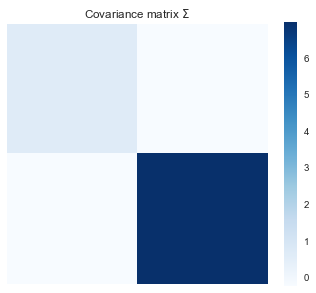

In [767]:
plt.imshow(cov_matrix_, extent=[0,1,0,1], cmap=cm.Blues)
plt.axis('off')
plt.colorbar()
plt.title("Covariance matrix $\\Sigma$");

In [768]:
def lda_posterior_prob(x, pi, mus, prec):
    """Posterior probability."""
    dx0 = x - mus[0]
    dx1 = x - mus[1]
    c0 = pi * np.exp(-0.5 * np.dot(dx0, prec @ dx0))
    c1 = (1-pi) * np.exp(-0.5 * np.dot(dx1, prec @ dx1))
    return c1 / (c0 + c1)


In [769]:
## Define the line parameters
normal_vec = precision_matrix_ @ (mus_[1] - mus_[0])
renormed_vec = normal_vec / np.linalg.norm(normal_vec)
e = np.random.rand(2); e /= np.linalg.norm(e)
support_vec = e - np.dot(renormed_vec, e) * renormed_vec

renormed_vec.dot(support_vec)

mu_avg = 0.5 * (mus_[0] + mus_[1])

b_ = normal_vec @ mu_avg + np.log(pi_bernouilli / (1-pi_bernouilli))
b_ = np.array([b_])

base_point = np.linalg.lstsq(normal_vec[None], b_, rcond=None)[0]

line_points_ = [
    base_point + t * support_vec
    for t in [6, 63]
]

line_points_ = np.array(line_points_)

In [770]:
xlims_ = [X_data[:, 0].min(), X_data[:, 0].max()]
x_breadth = 0.6
xlims_[0] = xlims_[0] - x_breadth * (xlims_[1] - xlims_[0])
xlims_[1] = xlims_[1] + x_breadth * (xlims_[1] - xlims_[0])

ylims_ = [X_data[:, 1].min(), X_data[:, 1].max()]
y_breadth = 0.1
ylims_[0] = ylims_[0] - y_breadth * (ylims_[1] - ylims_[0])
ylims_[1] = ylims_[1] + y_breadth * (ylims_[1] - ylims_[0])

xar = np.linspace(*xlims_, 41)
yar = np.linspace(*ylims_, 51)

xg, yg = np.meshgrid(xar, yar)
grid_points_ = np.dstack((xg, yg))

grid_points_ = grid_points_.reshape(np.prod(xg.shape), 2)

postprob_grid = np.array([
    lda_posterior_prob(x, pi_bernouilli, mus_, precision_matrix_)
    for x in grid_points_
])

postprob_grid = postprob_grid.reshape(*xg.shape)

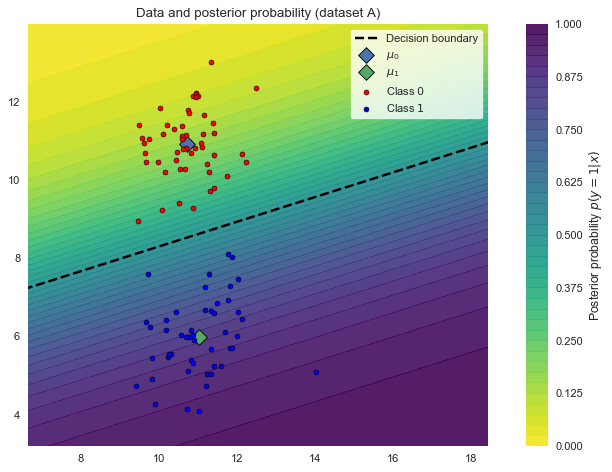

In [771]:
fig = plt.figure(figsize=(8, 6), dpi=80)

cf_ = plt.contourf(xg, yg, postprob_grid, levels=40,
                   zorder=-1, alpha=0.9,
                   cmap=cm.viridis_r)

cbar_ = fig.colorbar(cf_)
cbar_.set_label("Posterior probability $p(y=1|x)$")

## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)

plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

plt.plot(*line_points_.T, c='k', lw=2.2, ls='--',
         label="Decision boundary")


legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.grid(False)
plt.axis('scaled')

plt.title("Data and posterior probability (dataset %s)" % dataset_id)

plt.xlim(*xlims_)
plt.ylim(*ylims_)
fig.tight_layout();

In [772]:
fig.savefig("images/lda-pointcloud-decisionbound-d%s.pdf" % dataset_id,
            bbox_inches='tight')

In [773]:
from scipy import stats

c0_prob = stats.multivariate_normal.pdf(
    grid_points_, mean=mus_[0], cov=cov_matrix_).reshape(*xg.shape)

c1_prob = stats.multivariate_normal.pdf(
    grid_points_, mean=mus_[1], cov=cov_matrix_).reshape(*xg.shape)

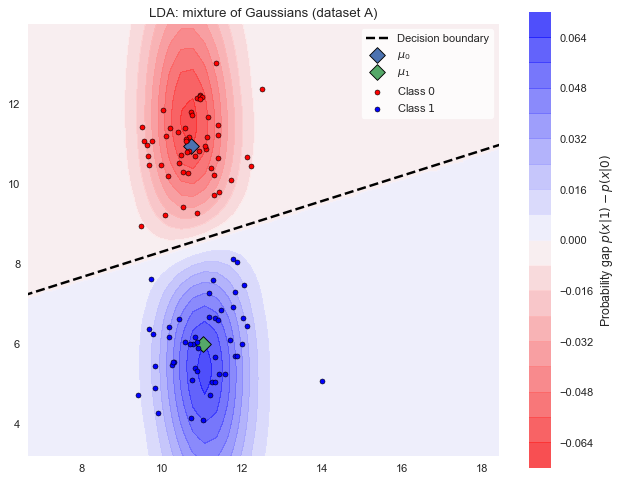

In [774]:
fig = plt.figure(figsize=(8, 6), dpi=80)

plt.contourf(xg, yg, c1_prob-c0_prob, levels=20, zorder=1, alpha=0.7,
             cmap=cm.bwr_r)

cbar_ = plt.colorbar()
cbar_.set_label("Probability gap $p(x|1)-p(x|0)$")

## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)


plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

plt.plot(*line_points_.T, c='k', lw=2.2, ls='--',
         label="Decision boundary")


legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.title("LDA: mixture of Gaussians (dataset %s)" % dataset_id)

plt.grid(False)
plt.axis('scaled')

fig.tight_layout()

plt.xlim(*xlims_)
plt.ylim(*ylims_);

In [775]:
fig.savefig('images/lda-pointcloud-mixture-probagap-d%s.pdf'%dataset_id,
            bbox_inches='tight')

# Logistic regression

In [776]:
## Create augmented data xaug = (1, x)
def augment_data(X):
    X_aug = np.empty((X.shape[0], 3))
    X_aug[:, 1:] = X
    X_aug[:, 0] = 1.
    return X_aug

X_data_aug = augment_data(X_data)
X_data_aug.shape

(100, 3)

In [777]:
from scipy.special import expit

log_expit = lambda x: -np.log(1 + np.exp(-x))

## Objective function, derivatives & Newton method for logistic regression

def log_likelihood(w: np.ndarray, X, y):
    s = y * X.dot(w)
    return np.sum(log_expit(s))

def gradient(w: np.ndarray, X, y):
    u = y * X.dot(w)
    s = (1 - expit(u)) * y
    summand = s[:, None] * X
    return summand.sum(axis=0)

def hessian(w: np.ndarray, X, y):
    u = y * X.dot(w)
    sig = expit(u)
    s = (sig - 1) * sig
    outers = np.matmul(X[:,:,None],
                       X[:,None])
    summand = s[:,None,None] * outers
    return np.sum(summand, axis=0)

In [778]:
def run_newton(w0, X_data, epsilon_data, num_iters=30, eps=1e-14, alpha=2.0, verb=True):
    r"""
    Run the Newton method for the logistic model
    
    Args:
        num_iters: maximal number of iterates for the Newton
    """
    w_iters = [w0]
    w = w0
    obj_values = [log_likelihood(w, X_data, epsilon_data)]
    for i in range(num_iters):
        grad = gradient(w, X_data, epsilon_data)
        hess = hessian(w, X_data, epsilon_data)
        
        dw_ = np.linalg.solve(hess, -grad)
        lbda = np.dot(dw_, grad)
        improvement_ = .5 * lbda ** 2
        
        w_new = w + alpha * dw_
        w = w_new
        w_iters.append(w)
        obj_values.append(log_likelihood(w, X_data, epsilon_data))
        if verb:
            print("Iter #%d - obj. improv:" % i, improvement_)
        if improvement_ <= eps:
            break
    return w_iters, np.array(obj_values)

In [779]:
def logistic_model(X_data, y_data, w0=None, eps=1e-15, alpha=1.0, verb=False):
    r"""
    
    Returns w_opt, (w_iters, value_iters) where:
        w_opt: trained weights
        w_iters: Newton iterates of the weights
        value_iters: value of the log-likelihood objective at each training step
    """
    epsilon_data = 2*y_data - 1
    if w0 is None: 
        w0 = np.zeros(3)

    w_iters, value_iters = run_newton(w0, X_data, epsilon_data,
                                      eps=eps, alpha=alpha, verb=verb)
    w_opt = w_iters[-1]
    return w_opt, (w_iters, value_iters)

w_opt, (w_iters, value_iters) = logistic_model(X_data_aug, y_data, verb=True)
print("Optimal likelihood value:", np.exp(value_iters[-1]))

Iter #0 - obj. improv: 3955.1519167052234
Iter #1 - obj. improv: 126.95250044828764
Iter #2 - obj. improv: 21.162569652467226
Iter #3 - obj. improv: 4.499402819822761
Iter #4 - obj. improv: 1.1060445095890772
Iter #5 - obj. improv: 0.2885313006731384
Iter #6 - obj. improv: 0.06688931022223293
Iter #7 - obj. improv: 0.012457465165538324
Iter #8 - obj. improv: 0.0019921827996856587
Iter #9 - obj. improv: 0.0002967817458491501
Iter #10 - obj. improv: 4.277636877697287e-05
Iter #11 - obj. improv: 6.052098164228758e-06
Iter #12 - obj. improv: 8.458743616251517e-07
Iter #13 - obj. improv: 1.1721294244854167e-07
Iter #14 - obj. improv: 1.6142669725247964e-08
Iter #15 - obj. improv: 2.213404992258428e-09
Iter #16 - obj. improv: 3.0253234678010813e-10
Iter #17 - obj. improv: 4.125626958602861e-11
Iter #18 - obj. improv: 5.616732866080364e-12
Iter #19 - obj. improv: 7.637340105466198e-13
Iter #20 - obj. improv: 1.0375255723263742e-13
Iter #21 - obj. improv: 1.4084765475894669e-14
Iter #22 - obj.

In [780]:
print(w_opt)

[165.70600271   7.46905868 -28.73551712]


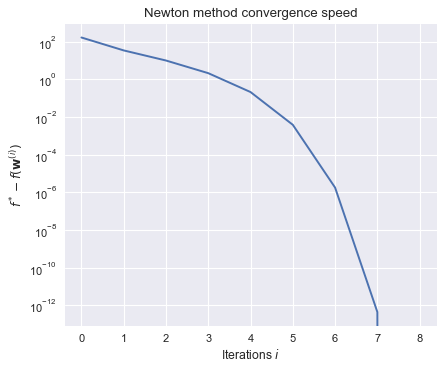

In [729]:
## Newton convergence plot, for good measure
fig = plt.figure(dpi=80)
plt.plot(value_iters[-1]-value_iters)
plt.xlabel("Iterations $i$")
plt.ylabel("$f^* - f(\\mathbf{w}^{(i)})$")
plt.title("Newton method convergence speed")
plt.yscale('log');

fig.savefig('images/logistic-newton-convergence.pdf')

In [730]:
def logistic_prob(x, w):
    xaug = np.ones(3)
    xaug[1:] = x
    sig = expit(w @ xaug)
    return sig

In [731]:
proba_grid = np.array([
    logistic_prob(x, w_opt)
    for x in grid_points_
])

proba_grid = proba_grid.reshape(*xg.shape)

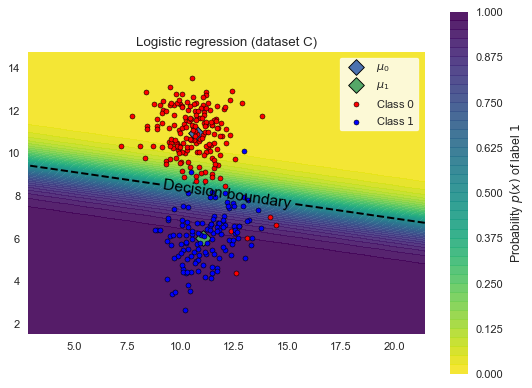

In [732]:
fig = plt.figure(figsize=(8, 6), dpi=80)

cf_ = plt.contourf(xg, yg, proba_grid, levels=40,
                   zorder=-1, alpha=0.9,
                   cmap=cm.viridis_r)

cs_ = plt.contour(cf_, levels=[0.5],  colors='k', linestyles='--')
plt.clabel(cs_, fmt={0.5: 'Decision boundary'}, fontsize=14)


## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)

plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.grid(False)
plt.axis('scaled')

plt.xlim(*xlims_)
plt.ylim(*ylims_)

plt.title("Logistic regression (dataset %s)" % dataset_id)

cbar_ = fig.colorbar(cf_)
cbar_.set_label("Probability $p(x)$ of label $1$");

In [733]:
fig.savefig('images/logisticreg-result-d%s.pdf'%dataset_id, bbox_inches='tight')

# Linear regression

In [734]:
def linear_model(X_data, y_data):
    r"""
    Solve the linear regression problem
    .. math::
        y = X w + epsilon
    
    using least squares.
    """
    wbar, *_ = np.linalg.lstsq(X_data, y_data, rcond=None)
    return wbar  # return parameter vector

In [735]:
wbar = linear_model(X_data_aug, y_data)
wbar

array([ 1.64015206,  0.01675461, -0.15897174])

In [736]:
grid_points_aug = np.empty((grid_points_.shape[0], 3))
grid_points_aug[:, 1:] = grid_points_
grid_points_aug[:, 0] = 1.

# run linear regression on entire grid
zg_linear_ = (grid_points_aug @ wbar).reshape(*xg.shape)

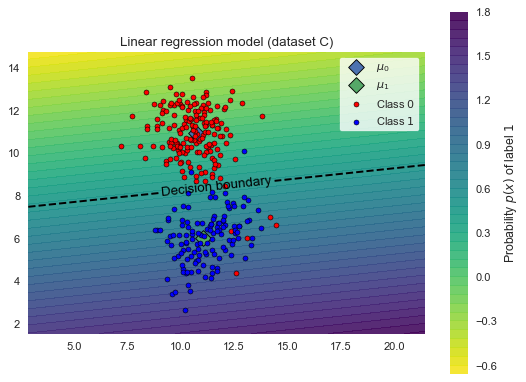

In [737]:
fig = plt.figure(figsize=(8, 6), dpi=80)

cf_ = plt.contourf(xg, yg, zg_linear_, levels=40,
                   zorder=-1, alpha=0.9,
                   cmap=cm.viridis_r)

cs_ = plt.contour(cf_, levels=[0.5],  colors='k', linestyles='--')
plt.clabel(cs_, fmt={0.5: 'Decision boundary'}, fontsize=12)

## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)

plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.grid(False)
plt.axis('scaled')

plt.xlim(*xlims_)
plt.ylim(*ylims_)

plt.title("Linear regression model (dataset %s)" % dataset_id)

cbar_ = fig.colorbar(cf_)
cbar_.set_label("Probability $p(x)$ of label $1$");

In [738]:
fig.savefig("images/linearreg-result-d%s.pdf"%dataset_id, bbox_inches='tight')

# QDA model



In [739]:
def qda_model(X_data, y_data):
    pi_bernouilli = np.mean(y_data == 1)

    mus_ = [
        np.mean(X_data[y_data == 0], axis=0),
        np.mean(X_data[y_data == 1], axis=0),
    ]

    cov_matrix0 = np.cov(X_data[y_data==0], rowvar=False)
    cov_matrix1 = np.cov(X_data[y_data==1], rowvar=False)
    covs_ = [cov_matrix0, cov_matrix1]
    return pi_bernouilli, mus_, covs_

In [740]:
pi_, mus_, covs_ = qda_model(X_data, y_data)

precs_ = [np.linalg.inv(c) for c in covs_]

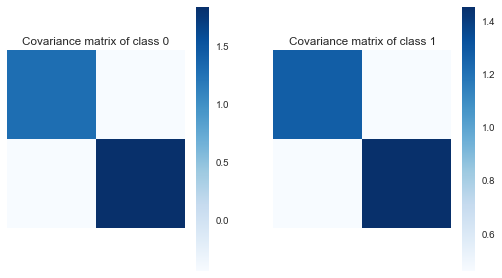

In [741]:
plt.figure(figsize=(9, 5))
plt.subplot(121)
plt.imshow(covs_[0], cmap=cm.Blues)
plt.title("Covariance matrix of class 0")
plt.colorbar()
plt.axis('off');

plt.subplot(122)
plt.imshow(covs_[1], cmap=cm.Blues)
plt.title("Covariance matrix of class 1")
plt.colorbar()
plt.axis('off');

In [742]:
def qda_posterior(x, pi, mus, precs):
    """Posterior probability."""
    mu0, mu1 = mus
    prec0, prec1 = precs
    
    dx0 = x - mu0
    dx1 = x - mu1
    
    c0 = pi * np.exp(-0.5 * np.dot(dx0, prec0 @ dx0))
    c1 = (1-pi) * np.exp(-0.5 * np.dot(dx1, prec1 @ dx1))
    return c1 / (c0 + c1)

In [743]:
z_qdaprob_ = [qda_posterior(x, pi_, mus_, precs_) for x in grid_points_]
z_qdaprob_ = np.array(z_qdaprob_).reshape(*xg.shape)

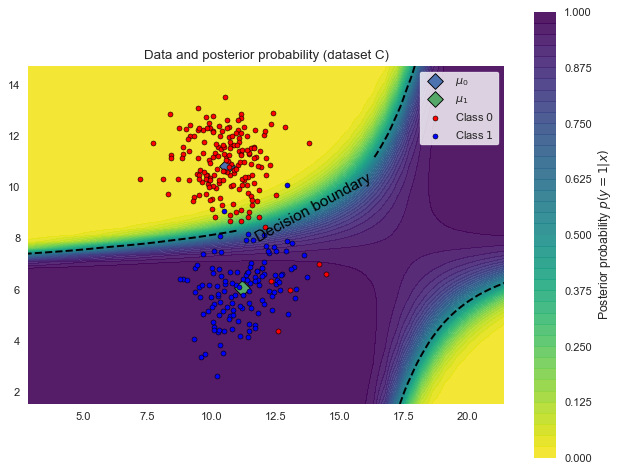

In [744]:
fig = plt.figure(figsize=(8, 6), dpi=80)

cf_ = plt.contourf(xg, yg, z_qdaprob_, levels=40,
                   zorder=-1, alpha=0.9,
                   cmap=cm.viridis_r)


cs_ = plt.contour(cf_, levels=[0.5],  colors='k', linestyles='--')
plt.clabel(cs_, fmt={0.5: 'Decision boundary'}, fontsize=14)

cbar_ = fig.colorbar(cf_)
cbar_.set_label("Posterior probability $p(y=1|x)$")

## Add the class centroids
for i, mu in enumerate(mus_):
    plt.scatter(*mu, s=100, marker='D',
                edgecolors='k', linewidths=.8,
                label="$\\mu_{%d}$" % i)

plt.scatter(*X_data[y_data==0].T, s=20, edgecolors='k',
            c='r', linewidths=.5, label="Class $0$")

plt.scatter(*X_data[y_data==1].T, s=20, edgecolors='k',
            c='b', linewidths=.5, label="Class $1$")

legend_ = plt.legend(frameon=1)
frame_ = legend_.get_frame()
frame_.set_color('white')

plt.grid(False)
plt.axis('scaled')

plt.title("Data and posterior probability (dataset %s)" % dataset_id)

plt.xlim(*xlims_)
plt.ylim(*ylims_)
fig.tight_layout();

In [745]:
fig.savefig('images/qda-cloud-decision-d%s.pdf' % dataset_id, bbox_inches='tight')

# Application

In [781]:
def missclassified_count(y_predict, y_real):
    return np.sum(y_predict != y_real) / y_real.size

In [782]:
data_train_test_files = list(zip(TRAIN_DATA_FILES, TEST_DATA_FILES))
data_train_test_files

[('data/trainA', 'data/testC'),
 ('data/trainB', 'data/testA'),
 ('data/trainC', 'data/testB')]

In [801]:
## Loop over all test files, train models and evaluate
WITH_QDA = True
miscounts_ = {}

for train_file, test_file in data_train_test_files:
    # Load data into arrays
    DATASET_ID = train_file[-1]
    print("DATASET %s" % DATASET_ID)
    data_train = pd.read_csv(train_file, sep=' ', header=None)
    data_test = pd.read_csv(test_file, sep=' ', header=None)
    print("Train dataset size:", data_train.shape)
    print("Test dataset size:", data_test.shape)
    
    X_train, y_train = data_train[[0, 1]].values, data_train[2].values
    X_test, y_test = data_test[[0, 1]].values, data_test[2].values
    
    ## RUN THE MODELS
    
    ### LDA
    
    pi_, mus_, cov_ = lda_model(X_train, y_train)
    prec_ = np.linalg.inv(cov_)  # precision matrix
    # probability of class 1
    probas_ = np.array([
        lda_posterior_prob(x, pi_, mus_, prec_) for x in X_test
    ])
    y_predict_test = (probas_ > 0.5).astype(int)  # make prediction along precision boundary
    probas_ = np.array([
        lda_posterior_prob(x, pi_, mus_, prec_) for x in X_train
    ])
    y_predict_train = (probas_ > 0.5).astype(int)  # make prediction along precision boundary
    miscounts_[DATASET_ID] = {
        "lda_train": missclassified_count(y_predict_train, y_train),
        "lda_test": missclassified_count(y_predict_test, y_test)
    }
    
    
    ### LOGISTIC REG
    X_train_aug = augment_data(X_train)  # augment data (add 1)
    X_test_aug = augment_data(X_test)
    
    # logistic_model is verbose so print something to announce we're running it
    print("Logistic regression on data %s:" % DATASET_ID)
    wbar_, (_, vals_) = logistic_model(X_train_aug, y_train,
                              eps=1e-16, alpha=1.0, verb=True)
    print("Learned weights:")
    print("\t", wbar_)
    print("Log-likelihood:", np.exp(vals_[-1]))
    print()
    
    # predict
    probas_ = expit(X_test_aug @ wbar_)
    y_predict_test = (probas_ > 0.5).astype(int)
    
    probas_ = expit(X_train_aug @ wbar_)
    y_predict_train = (probas_ > 0.5).astype(int)
    miscounts_[DATASET_ID].update({
        "logistic_train": missclassified_count(y_predict_train, y_train),
        "logistic_test": missclassified_count(y_predict_test, y_test)
    })
    
    
    ### Linear model
    # we already have the augmented X_data
    wbar_ = linear_model(X_train_aug, y_train)
    # predict
    y_predict_test = (X_test_aug @ wbar_ > 0.5).astype(int)
    y_predict_train = (X_train_aug @ wbar_ > 0.5).astype(int)
    miscounts_[DATASET_ID].update({
        "linear_train": missclassified_count(y_predict_train, y_train),
        "linear_test": missclassified_count(y_predict_test, y_test)
    })
    
    if WITH_QDA:
        ### QDA
        print("QDA model on data %s" % DATASET_ID)
        pi_, mus_, covs_ = qda_model(X_train, y_train)
        print("Learned params:")
        print("pi\t", pi_)
        print("mus\t", mus_)
        print("covs:")
        for c in covs_:
            print(c)
        precs_ = [np.linalg.inv(c) for c in covs_]
        # Compute posterior proba for test
        proba_ = np.array([qda_posterior(x, pi_, mus_, precs_) for x in X_test])
        y_predict_test = (proba_ > 0.5).astype(int)
        # Compute posterior proba for train set
        proba_ = np.array([qda_posterior(x, pi_, mus_, precs_) for x in X_train])
        y_predict_train = (proba_ > 0.5).astype(int)

        miscounts_[DATASET_ID].update({
            "qda_train": missclassified_count(y_predict_train, y_train),
            "qda_test": missclassified_count(y_predict_test, y_test)
        })
        print()


DATASET A
Train dataset size: (100, 3)
Test dataset size: (300, 3)
Logistic regression on data A:
Iter #0 - obj. improv: 3955.1519167052234
Iter #1 - obj. improv: 126.95250044828764
Iter #2 - obj. improv: 21.162569652467226
Iter #3 - obj. improv: 4.499402819822761
Iter #4 - obj. improv: 1.1060445095890772
Iter #5 - obj. improv: 0.2885313006731384
Iter #6 - obj. improv: 0.06688931022223293
Iter #7 - obj. improv: 0.012457465165538324
Iter #8 - obj. improv: 0.0019921827996856587
Iter #9 - obj. improv: 0.0002967817458491501
Iter #10 - obj. improv: 4.277636877697287e-05
Iter #11 - obj. improv: 6.052098164228758e-06
Iter #12 - obj. improv: 8.458743616251517e-07
Iter #13 - obj. improv: 1.1721294244854167e-07
Iter #14 - obj. improv: 1.6142669725247964e-08
Iter #15 - obj. improv: 2.213404992258428e-09
Iter #16 - obj. improv: 3.0253234678010813e-10
Iter #17 - obj. improv: 4.125626958602861e-11
Iter #18 - obj. improv: 5.616732866080364e-12
Iter #19 - obj. improv: 7.637340105466198e-13
Iter #20 - 

In [792]:
print(miscounts_)

miscounts_ = pd.DataFrame(miscounts_)
miscounts_['mean'] = miscounts_.mean(axis=1)
miscounts_

{'A': {'lda_train': 0.0, 'lda_test': 0.03666666666666667, 'logistic_train': 0.0, 'logistic_test': 0.03666666666666667, 'linear_train': 0.0, 'linear_test': 0.03666666666666667, 'qda_train': 0.0, 'qda_test': 0.04}, 'B': {'lda_train': 0.035, 'lda_test': 0.01, 'logistic_train': 0.01, 'logistic_test': 0.0, 'linear_train': 0.02, 'linear_test': 0.01, 'qda_train': 0.01, 'qda_test': 0.01}, 'C': {'lda_train': 0.04666666666666667, 'lda_test': 0.035, 'logistic_train': 0.03, 'logistic_test': 0.06, 'linear_train': 0.02666666666666667, 'linear_test': 0.06, 'qda_train': 0.02666666666666667, 'qda_test': 0.06}}


,A,B,C,mean
lda_train,0.000000,0.035,0.046667,0.027222
lda_test,0.036667,0.010,0.035000,0.027222
logistic_train,0.000000,0.010,0.030000,0.013333
logistic_test,0.036667,0.000,0.060000,0.032222
linear_train,0.000000,0.020,0.026667,0.015556
linear_test,0.036667,0.010,0.060000,0.035556
qda_train,0.000000,0.010,0.026667,0.012222
qda_test,0.040000,0.010,0.060000,0.036667


In [793]:
print(miscounts_.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &         A &      B &         C &      mean \\
\midrule
lda\_train      &  0.000000 &  0.035 &  0.046667 &  0.027222 \\
lda\_test       &  0.036667 &  0.010 &  0.035000 &  0.027222 \\
logistic\_train &  0.000000 &  0.010 &  0.030000 &  0.013333 \\
logistic\_test  &  0.036667 &  0.000 &  0.060000 &  0.032222 \\
linear\_train   &  0.000000 &  0.020 &  0.026667 &  0.015556 \\
linear\_test    &  0.036667 &  0.010 &  0.060000 &  0.035556 \\
qda\_train      &  0.000000 &  0.010 &  0.026667 &  0.012222 \\
qda\_test       &  0.040000 &  0.010 &  0.060000 &  0.036667 \\
\bottomrule
\end{tabular}



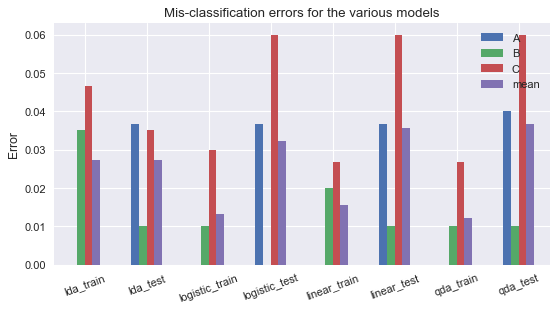

In [796]:
fig = plt.figure(figsize=(8,4), dpi=80)
ax = fig.add_subplot(111)
miscounts_.plot.bar(ax=ax)
ax.set_ylabel("Error")
plt.xticks(rotation=20)
ax.set_title("Mis-classification errors for the various models");

In [797]:
if WITH_QDA:
    filename = 'images/misclassification-with-qda.pdf'
else:
    filename = 'images/misclassification.pdf'
print("Saving figure to  %s" % filename)
fig.savefig(filename, bbox_inches='tight')

Saving figure to  images/misclassification-with-qda.pdf
